In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 

from models import sentimentAnalyze
from run_model import run_model
from my_dataset import MyDataset
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

trainData  = pd.read_csv('../data/train_E6oV3lV.csv')
testData = pd.read_csv('../data/test_tweets_anuFYb8.csv')
print(trainData.head())
print(testData.head())


dataSet = trainData.append(testData, ignore_index=True)

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

# remove twitter handles (@user)
dataSet['tidy_tweet'] = np.vectorize(remove_pattern)(dataSet['tweet'], "@[\w]*")

# remove special characters, numbers, punctuations
dataSet['tidy_tweet'] = dataSet['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

# remove short word
dataSet['tidy_tweet'] = dataSet['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# tokenize
tokenized_Data = dataSet['tidy_tweet'].apply(lambda x: x.split())

for i in range(len(tokenized_Data)):
    tokenized_Data[i] = ' '.join(tokenized_Data[i])
dataSet['tidy_tweet'] = tokenized_Data

   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation
      id                                              tweet
0  31963  #studiolife #aislife #requires #passion #dedic...
1  31964   @user #white #supremacists want everyone to s...
2  31965  safe ways to heal your #acne!!    #altwaystohe...
3  31966  is the hp and the cursed child book up for res...
4  31967    3rd #bihday to my amazing, hilarious #nephew...
<ipython-input-1-a384644f6a94>:36: FutureWarning: The default value of regex will change from True to False in a future version.
  dataSet['tidy_tweet'] = dataSet['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
# bow_vectorizer = CountVectorizer(max_df=0.85, min_df=2, max_features=1024, stop_words='english')
bow_vectorizer = CountVectorizer(max_features=2048, stop_words='english')
# bag-of-words feature matrix
dataBow = bow_vectorizer.fit_transform(dataSet['tidy_tweet'])

# print(dataBow.shape)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = dataBow[:31962, :]
test_bow = dataBow[31962:, :]

# trainLabel = np.zeros((31962, 2))
# for i in range(31962):
#     trainLabel[trainData['label'][i]] = 1

xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, trainData['label'], random_state=42, test_size=0.2)

print(type(xtrain_bow))
print(type(ytrain))
print(xtrain_bow.shape)
print(ytrain.shape)
print(xvalid_bow.shape)
print(yvalid.shape)

<class 'scipy.sparse.csr.csr_matrix'>
<class 'pandas.core.series.Series'>
(25569, 2048)
(25569,)
(6393, 2048)
(6393,)


In [15]:
train_dataset = MyDataset(xtrain_bow.A.astype(np.double), np.array(ytrain))
valid_dataset = MyDataset(xvalid_bow.A.astype(np.double), np.array(yvalid))

# model = sentimentAnalyze()
model, _est_loss, _est_acc = run_model(model, running_mode='train', train_set=train_dataset,
    valid_set = valid_dataset, batch_size = 1000, learning_rate=5e-3,
    n_epochs = 30, stop_thr = 1e-6, shuffle=False)



epoch: 1
train loss: 0.1621108850073144
valid loss: 0.44197159112612106
train acc: 92.694885
valid acc: tensor(91.2874)
epoch: 2
train loss: 0.1605051817422871
valid loss: 0.4468284546138651
train acc: 92.79397
valid acc: tensor(90.3355)
epoch: 3
train loss: 0.15715310398151489
valid loss: 0.44457409332961334
train acc: 92.69851
valid acc: tensor(90.3057)
epoch: 4
train loss: 0.1611747120639939
valid loss: 0.4738176688197041
train acc: 92.61121
valid acc: tensor(91.3004)
epoch: 5
train loss: 0.15313040926464463
valid loss: 0.4601577006281311
train acc: 92.99489
valid acc: tensor(91.2589)
epoch: 6
train loss: 0.15986161008450706
valid loss: 0.45977354132013154
train acc: 92.60329
valid acc: tensor(91.1939)
epoch: 7
train loss: 0.1548838795611593
valid loss: 0.45117967681978216
train acc: 92.90049
valid acc: tensor(91.1614)
epoch: 8
train loss: 0.1551597069525312
valid loss: 0.4517745191558156
train acc: 92.76482
valid acc: tensor(91.2666)
epoch: 9
train loss: 0.15735776282974137
valid l

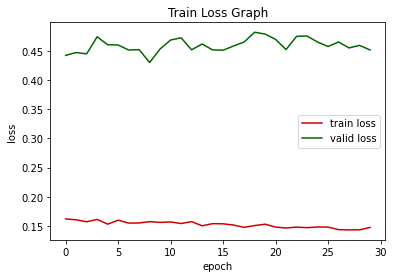

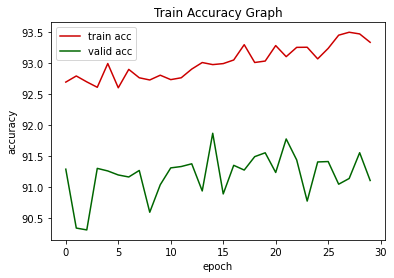

torch.Size([6393, 2])
tensor([[ 2.6723, -3.0578],
        [ 2.2130, -2.5738],
        [ 2.3340, -2.6914],
        ...,
        [ 1.9006, -2.2112],
        [ 2.4331, -2.7932],
        [-1.3392,  1.1973]], dtype=torch.float64, grad_fn=<AddmmBackward>)
tensor([False, False, False,  ..., False, False,  True])
0.5305164319248827


In [16]:
plt.title('Train Loss Graph')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(_est_loss['train'], color=(0.8,0.,0.), label='train loss')
plt.plot(_est_loss['valid'], color=(0.,0.4,0.), label='valid loss')
plt.legend()
plt.show()

plt.title('Train Accuracy Graph')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(_est_acc['train'], color=(0.8,0.,0.), label='train acc')
plt.plot(_est_acc['valid'], color=(0.,0.4,0.), label='valid acc')
plt.legend()
plt.show()

model.eval()
prediction = model.forward((torch.Tensor(xvalid_bow.A).double())) # predicting on the validation set
prediction_int = prediction[:, 1] >= prediction[:, 0]
# prediction_int = prediction_int.numpy().astype(np.int)

print(prediction.shape)
print(prediction)
# print(yvalid)
print(prediction_int)
score = f1_score(yvalid, prediction_int) # calculating f1 score
print(score)

In [14]:
test_pred = model.forward((torch.Tensor(test_bow.A).double()))
test_pred_int = test_pred[:, 1] >= test_pred[:, 0]
testData['label'] = test_pred_int
submission = testData[['id','label']]
submission.to_csv('../output/sub_lreg_bow.csv', index=False) # writing data to a CSV file